# Primerjava pristopov za luščenje ključnih fraz na povzetkih člankov s ključno besedo "Covid-19"

V tem zvezku predstavljamo primerjavo pristopov za luščenje ključnih besed iz nabora povzetkov člankov s ključno besedo "Longevity" v zbirki PubMed.

Predstavili bomo objektivno primerjavo pristopov za luščenje besed. Primerjali bomo izluščene besede s ključnimi besedami, ki so jih označili avtorji člankov. Za vsako metodo bomo prikazali povprečno preciznost (precision), priklic (recall) in mero F1.

In [1]:
import string
import ast

import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import yake
import rake
from operator import is_not
from functools import partial

from textsemantics import specific_words
from utils.scores import (
    precision, recall, average_precision, average_recall, average_f_score,
    take_n, score_in_len_range
)
from bert_keyword_extractor import TransformerKeywordExtractor

# max len of keyphrase
N_GRAM_LEN = 3

Naložimo metapodatke in dokumente iz zbirke in dokumente preprocesiramo in izluščimo posamezne besede.

In [3]:
nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]
        # lematizer in rare cases produce empty strings - removing them
        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
        
    return preprocessed

df = pd.read_pickle("pubmed-covid-19.pkl")
len_before = len(df)

# izpusti članke brez ključnih besed - izbriši None vrednosti v senznamu ključnih besed
# po brisanju None vrednosti nekatera besedila izgubijo ključne besede, odstrani jih
df = df[~df["keywords"].isnull()]
df["keywords"] = df["keywords"].apply(lambda x: [k for k in x if k is not None])
# izputsti kljucne besede z vec kot N_GRAM_LEN besedami
# e.g. if N_GRAM_LEN == 3 we skip just 2% words
df["keywords"] = df["keywords"].apply(lambda x: [k for k in x if len(k.split()) <= N_GRAM_LEN])
df = df[df["keywords"].apply(len) != 0]

# some keywords were not splited on seperate keyword by PubMed so keyword is comma separaed string
# of keywords, others have coma which is part of the keyword. It is hard to distinguish both
# so we are dropping 92 
print("Z vejicami", len(df))
df = df[~df["keywords"].apply(lambda x: any(", " in k for k in x))]
print("Brez vejic", len(df))

# izpusti prazne abstracte
df = df[df["abstract"].str.len() >= 100]

tokens_list = preprocess(df["abstract"])

print(f"Število dokumentov: {len(df)}/{len_before}")

Z vejicami 6656
Brez vejic 6623
Število dokumentov: 6623/10000


Poglejmo si podatkte in izseke prvih 5 dokumentov

In [7]:
df.head()

,title,abstract,journal,authors,mesh_terms,keywords,pubmed_id,year
0,Challenges in the management of paediatric sur...,As a result of the coronavirus disease (COVID-...,African journal of paediatric surgery : AJPS,"[Roshan Chanchlani, Reyaz Ahmad, Mahendra Kuma...","[COVID-19, Child, Humans, Pandemics, SARS-CoV-...","[COVID-19, paediatric surgery, pandemic, proto...",34916351,2022
1,COVID-19 and chronic diabetes: the perfect sto...,The coronavirus disease 2019 pandemic is predi...,Journal of medical case reports,"[Genesis P Aguillón-Durán, Ericka Prieto-Martí...","[Adult, COVID-19, Communicable Disease Control...","[COVID-19, Diabetes mellitus, Diagnostic delay...",34915933,2021
3,Laparoscopic surgery produced less surgical sm...,The SARS-CoV2 virus has been identified in abd...,BMC surgery,"[Voraboot Taweerutchana, Tharathorn Suwatthana...","[COVID-19, Cadaver, Humans, Laparoscopy, Pande...","[COVID-19, Contamination, Laparoscopic surgery...",34915893,2021
4,"Expectations, concerns and experiences of reha...","The COVID-19 pandemic, as well as efforts to p...",BMC health services research,"[Kübra Altinok, Fabian Erdsiek, Yüce Yilmaz-As...","[COVID-19, Humans, Medicine, Motivation, Pande...","[COVID-19, Health service delivery, Patient-ce...",34915890,2021
5,Medical students' perceptions and coping strat...,The unfolding of the COVID-19 pandemic during ...,BMC medical education,"[Wurth Sophie, Sader Julia, Cerutti Bernard, B...","[Adaptation, Psychological, COVID-19, Humans, ...","[COVID-19, Coping strategies, Medical students...",34915888,2021


Sedaj bomo pridobili ključne besede z vsako od primerjanih metod:
- [TF-IDF](https://github.com/biolab/text-semantics/blob/main/examples/04_03_specific_words_with_tfidf.ipynb)
- [Metoda z vložitvami:](https://github.com/biolab/text-semantics/blob/main/examples/04_01_specific_words_with_embeddings.ipynb) samo na besedah v dokumentih
- [RAKE](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [Yake!](https://onlinelibrary.wiley.com/doi/abs/10.1002/9780470689646.ch1)
- [TextRank](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)

In [8]:
%%time 
def tfidf_keywords(tokens):
    joined_texts = [" ".join(tokens) for tokens in tokens]
    vectorizer = TfidfVectorizer(ngram_range=(1, N_GRAM_LEN))
    X = vectorizer.fit_transform(joined_texts)
    words = vectorizer.get_feature_names()

    keywords = []
    for row in X:
        features = [(words[i], row[0, i]) for i in row.nonzero()[1]]
        keywords.append(sorted(features, key=lambda tup: tup[1], reverse=True))
    return keywords


tfidf_keywords = tfidf_keywords(tokens_list)
tfidf_keywords = [[x for x, _ in wds] for wds in tfidf_keywords]

/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 1min 6s, sys: 587 ms, total: 1min 7s
Wall time: 1min 7s


In [9]:
%%time 
stop_path = "utils/english-stopwords.txt"
rake_object = rake.Rake(stop_path, max_words_length=3)
def rake_method(text):    
    kw = rake_object.run(text)
    # rake works on unormalized texts so normalize them afterwards
    return [" ".join(lemmatizer.lemmatize(w) for w in x.split()) for x, _ in kw if x not in stop_words]

rake_keywords = [rake_method(txt) for txt in df["abstract"]]

CPU times: user 18.5 s, sys: 3.32 ms, total: 18.5 s
Wall time: 18.5 s


In [10]:
%%time 
custom_kw_extractor = yake.KeywordExtractor(lan="en", n=3, top=20)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [" ".join(lemmatizer.lemmatize(w) for w in x.split()) for x, _ in kw]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 11min 39s, sys: 426 ms, total: 11min 40s
Wall time: 11min 40s


In [11]:
%%time
import spacy
import pytextrank

def text_rank(texts):
    nlp = spacy.load("en_core_web_sm")
    nlp.add_pipe("textrank")
    
    def text_rank(text):
        doc = nlp(text)
        return [" ".join(lemmatizer.lemmatize(w) for w in x.text.split()) 
                for x in doc._.phrases if len(x.text.split()) <= N_GRAM_LEN]

    return [text_rank(t) for t in texts]

text_rank_keywords = text_rank(df["abstract"])

CPU times: user 6min 5s, sys: 574 ms, total: 6min 6s
Wall time: 6min 6s


In [12]:
%%time

def get_kws(model_path):
    extractor = TransformerKeywordExtractor(model_path)
    bert_keywords = extractor.extract_keywords(df['abstract'])
    del extractor
    return [[w for w, _ in kws] for kws in bert_keywords]
        
crosloengual_keywords = get_kws('models/crosloeng')
mbert_keywords = get_kws('models/mbert')

  0%|          | 0/8 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 7777
  Batch size = 8


/home/primoz/text-semantics/examples/bert_keyword_extractor.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(predictions).to(self.device), dim=2)
loading configuration file models/mbert/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "finetuning_task": "ner",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B",
    "1": "I",
    "2": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B": 0,
    "I": 1,
    "O": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,


  0%|          | 0/8 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 7374
  Batch size = 8


CPU times: user 4min 19s, sys: 4min 11s, total: 8min 30s
Wall time: 7min 55s


In [13]:
methods = [
    # ("Emb - document", emb_doc_keywords),
    ("TFIDF", tfidf_keywords),
    ("RAKE", rake_keywords),
    ("YAKE", yake_keywords),
    ("TextRank", text_rank_keywords),
    ("mBert", mbert_keywords),
    ("CroSloEngual", crosloengual_keywords),
]

Ko imamo pridobljene ključne besede, si izpišemo povprečno število ključnih besed in najmanjše število ključnih besed, ki jih vsaka od metod vrne. Te statitike nam služijo zgolj, da vidimo ali je bila izluščitev besed uspešna. Nekatere metode omogočajo nastavljanje števila najbolj pomembnih ključnih besed zato imamo tam tipično manj ključnih besed na besedilo.

In [14]:
for name, kw in methods:
    print(
        f"{name} - Povprečno število besed:", 
        f"{sum(len(x) for x in kw) / len(kw):.1f}",
        "Minimalno število specifičnih besed:",
        min(len(x) for x in kw)
    )

TFIDF - Povprečno število besed: 337.0 Minimalno število specifičnih besed: 36
RAKE - Povprečno število besed: 64.8 Minimalno število specifičnih besed: 6
YAKE - Povprečno število besed: 20.0 Minimalno število specifičnih besed: 17
TextRank - Povprečno število besed: 57.8 Minimalno število specifičnih besed: 6
mBert - Povprečno število besed: 2.2 Minimalno število specifičnih besed: 0
CroSloEngual - Povprečno število besed: 2.4 Minimalno število specifičnih besed: 0


Izračunajmo natančnosti s pripravljenimi merami in jih izrišimo. Izračunamo povprečno preciznost, priklic in mero F1 za različno število izbranih najbolj pomembnih ključnih besed. Z vsako metodo smo pridobili seznam ključnih besed, ki je razvrščen po pomembnosti. Za namen izrisa grafov smo se odločili, da izračunamo vse tri mere za število ključnih besed v intervalu med 1 in 20. Na ta način vidimo kako uspešna je metoda glede na izbrano število ključnih besed.

Izrišemo po en graf za vsako od mer - graf, ki prikazuje vrednost mere v odvisnosti od števila izbranih najboljših ključnih besed. Četrti graf prikazuje preciznost in priklic na enem grafu. V tem grafu ima metoda krivuljo iz večih točk. Vsaka od točk predstavlja preciznost in priklic za različno število izbranih ključnih besede. Metoda katere krivulja je bližje zgornjemu desnemu kotu, je boljša. 


In [15]:
kw = df['keywords'].tolist()
kw = [[" ".join(lemmatizer.lemmatize(x) for x in t.lower().split()) for t in k] for k in kw]

assert len(kw) == len(df)

precisions = [score_in_len_range(pred, kw, average_precision) for _, pred in methods]
recalls = [score_in_len_range(pred, kw, average_recall)  for _, pred in methods]
f_scores = [score_in_len_range(pred, kw, average_f_score)  for _, pred in methods]

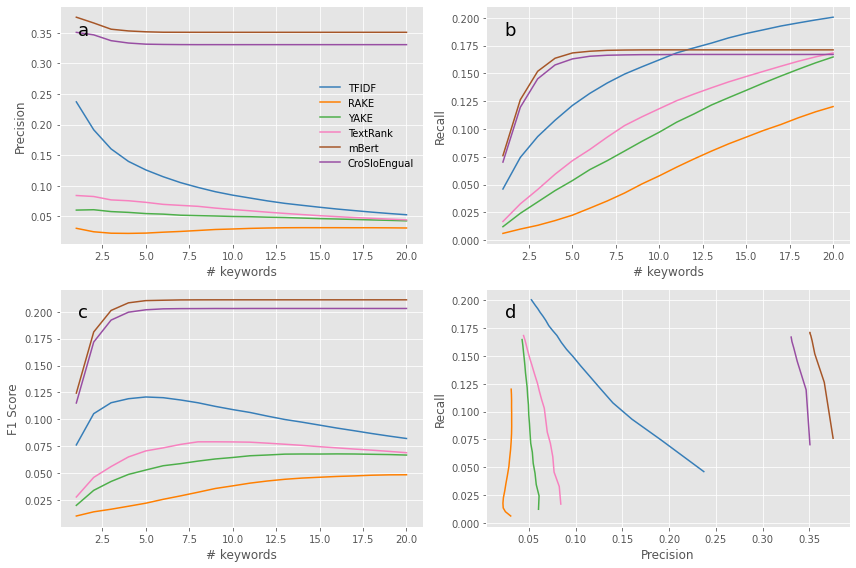

In [22]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

plt.style.use('ggplot')
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')

scores = (
    ("Precision", precisions),
    ("Recall", recalls),
    ("F1 Score", f_scores),
)
labels = ["a", "b", "c"]
for i, (title, sc) in enumerate(scores):
    ax1 = plt.subplot(2, 2, i + 1)
    for p, (l, _), c in zip(sc, methods, CB_color_cycle):
        plt.plot(range(1, 21), p, label=l, color=c)
    if i == 0:
        l = plt.legend()
        l.get_frame().set_linewidth(0.0)
        l.get_frame().set_facecolor('none')
    plt.xlabel("# keywords")
    plt.ylabel(title)
    ax1.text(0.05, 0.88, labels[i], transform=ax1.transAxes, fontsize=18)
        
ax1 = plt.subplot(2, 2, 4)
for p, r, (l, _), c in zip(precisions, recalls, methods, CB_color_cycle):
    plt.plot(p, r, label=l, color=c)
plt.xlabel("Precision")
plt.ylabel("Recall")
ax1.text(0.05, 0.88, "d", transform=ax1.transAxes, fontsize=18)
# plt.suptitle("Keyphrases")

plt.tight_layout()
plt.savefig("keyphrase-covid-comparison.eps")

In [17]:
def mrr(pred, true_keywords):   
    def first_idx(p, kw):
        return next((p.index(el) + 1 for el in p if el in kw), None)
    ranks = [first_idx(pr, k) for pr, k in zip(pred, true_keywords)]
    return sum(1/r if r is not None else 0 for r in ranks)/len(ranks)

def take_same_number(pred, true):
    return [p[:len(t)] for p, t in zip(pred, true)]

def score_same_len(predictions, keywords, score_method):
    return score_method(take_same_number(predictions, keywords), keywords)

def map_(predictions, keywords):
    # http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html
    def ap(pred, kws):
        appearances = [1 if p in kws else 0 for p in pred]
        p_k = [sum(appearances[:i+1])/(i+1) for i, a in enumerate(appearances) if a > 0]
        return sum(p_k) / len(kws)
    
    return sum(ap(p, k) for p, k in zip(predictions, keywords)) / len(predictions)

In [18]:
precisions_same_number_keywords = [score_same_len(pred, kw, average_precision) for _, pred in methods]
recall_same_number_keywords = [score_same_len(pred, kw, average_recall) for _, pred in methods]
f1_same_number_keywords = [score_same_len(pred, kw, average_f_score) for _, pred in methods]
mmrrs = [mrr(pred, kw) for _, pred in methods]
maps = [map_(pred, kw) for _, pred in methods]

In [19]:
df_res = pd.DataFrame({
    "Precission": precisions_same_number_keywords,
    "Recall": recall_same_number_keywords,
    "F1": f1_same_number_keywords,
    "MRR": mmrrs,
    "MAP": maps,
}, index=[n for n, _ in methods])

df_res.style.bar(color='#d65f5f', vmin=0)

,Precission,Recall,F1,MRR,MAP
TFIDF,0.122142,0.122142,0.122142,0.348839,0.101540
RAKE,0.023435,0.023404,0.023417,0.095113,0.032772
YAKE,0.055263,0.055253,0.055257,0.150672,0.043915
TextRank,0.071937,0.071905,0.071919,0.186250,0.057342
mBert,0.352274,0.165446,0.209863,0.468015,0.136199
CroSloEngual,0.332443,0.160419,0.201731,0.451000,0.128929


## Histogrami

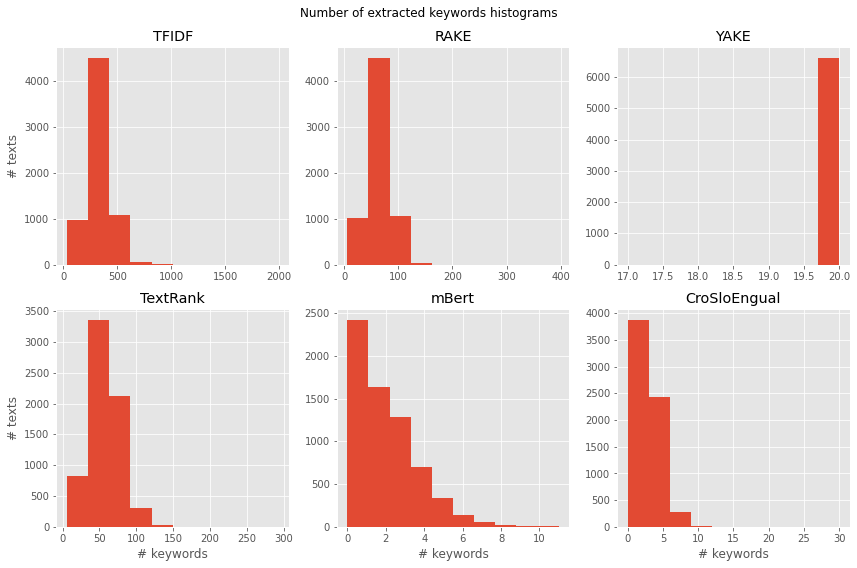

In [23]:
fig = plt.figure(figsize=(12,8))

for i, (m, kw) in enumerate(methods):
    plt.subplot(2, 3, i + 1)
    plt.hist([len(k) for k in kw])
    plt.title(m)
    if i in [3, 4, 5]:
        plt.xlabel("# keywords")
    if i in [0, 3]:
        plt.ylabel("# texts")
    
plt.suptitle("Number of extracted keywords histograms")
plt.tight_layout()
plt.savefig("num-extracted-words-covid.eps")

## Besedila in ključne besede

In [21]:
import random
from random import randint
from IPython.display import display, Markdown

md = ""
random.seed(30)
random_texts = [randint(0, len(df)) + 1 for i in range(10)]
for i in random_texts:
    md += f"## {df['title'].iloc[i]}\n\n"
    md += df['abstract'].iloc[i] + "\n\n"
    md += f"**Keywords by author**: {', '.join(df['keywords'].iloc[i])}\n\n"
    for m, kw in methods:
        md += f"**{m}**: {', '.join(kw[i][:10])}\n\n"
        

display(Markdown(md))

## Assessment of antiphospholipid antibodies and calprotectin as biomarkers for discriminating mild from severe COVID-19.

To explore the association of thrombo-inflammatory biomarkers with severity in coronavirus disease (COVID-19), we measured antiphospholipid antibodies (aPL) and calprotectin in sera of COVID-19 patients.
Anticardiolipin antibodies (aCL) and anti-β2-glycoprotein I antibodies were measured using enzyme-linked immunosorbent assay (ELISA) and multiplex flow immunoassay (MFIA) in hospitalized COVID-19 patients (N = 105) and healthy controls (N = 38). Anti-phosphatidylserine/prothrombin antibodies, calprotectin, and C-reactive protein (CRP) levels were also measured. We assessed the potential correlation between calprotectin levels and various laboratory parameters that were measured during the hospitalization period. After stratifying COVID-19 patients into two groups by their oxygenation status or acute respiratory distress syndrome presentation, the discriminatory performance of each biomarker was evaluated.
A high proportion of COVID-19 patients (29.5%, 31/105) had low aCL IgM titers that were detectable by ELISA but mostly below the detection limit of MFIA. Calprotectin levels in severe groups of COVID-19 were significantly higher than those in non-severe groups, while CRP levels revealed no significant differences. Serum calprotectin levels showed strong to moderate degree of correlation with other routinely used parameters including peak levels of CRP, ferritin, procalcitonin, BUN, and neutrophil-to-lymphocyte ratio, but a negative correlation with minimal lymphocyte count and CD4+ T cells. The discriminatory performance was highest for calprotectin in discriminating severe groups of COVID-19.
Serum calprotectin levels were significantly elevated in severe COVID-19 cases. The prevalence of clinically significant aPL did not differ. The link between calprotectin and inflammatory pathway in COVID-19 may help improve the management and outcomes of COVID-19 patients.

**Keywords by author**: COVID-19, anticardiolipin antibodies, antiphospholipid antibodies, calprotectin, severity

**TFIDF**: calprotectin, calprotectin level, serum calprotectin level, severe group covid19, serum calprotectin, discriminatory performance, mfia, level, acl, apl

**RAKE**: link immunosorbent assay, multiplex flow immunoassay, various laboratory parameter, minimal lymphocyte count, measure use enzyme, discriminating severe group, clinically significant apl, measure antiphospholipid antibody, crp level reveal, serum calprotectin level

**YAKE**: measure antiphospholipid antibody, coronavirus disease, calprotectin, explore the association, association of thrombo-inflammatory, severity in coronavirus, calprotectin level, level, patient, antibody

**TextRank**: N, healthy control, COVID-19 patient, hospitalize COVID-19 patient, calprotectin level, Serum calprotectin level, severe COVID-19 case, non-severe group, COVID-19, severe group

**mBert**: calprotectin, covid-19, covid-19.

**CroSloEngual**: calprotectin, coronavirus, covid-19, covid-19.

## Social vulnerability and county stay-at-home behavior during COVID-19 stay-at-home orders, United States, April 7-April 20, 2020.

Early COVID-19 mitigation relied on people staying home except for essential trips. The ability to stay home may differ by sociodemographic factors. We analyzed how factors related to social vulnerability impact a community's ability to stay home during a stay-at-home order.
Using generalized, linear mixed models stratified by stay-at-home order (mandatory or not mandatory), we analyzed county-level stay-at-home behavior (inferred from mobile devices) during a period when a majority of United States counties had stay-at-home orders (April 7-April 20, 2020) with the Centers for Disease Control and Prevention Social Vulnerability Index (CDC SVI).
Counties with higher percentages of single-parent households, mobile homes, and persons with lower educational attainment were associated with lower stay-at-home behavior compared with counties with lower respective percentages. Counties with higher unemployment, higher percentages of limited-English-language speakers, and more multi-unit housing were associated with increases in stay-at-home behavior compared with counties with lower respective percentages. Stronger effects were found in counties with mandatory orders.
Sociodemographic factors impact a community's ability to stay home during COVID-19 stay-at-home orders. Communities with higher social vulnerability may have more essential workers without work-from-home options or fewer resources to stay home for extended periods, which may increase risk for COVID-19. Results are useful for tailoring messaging, COVID-19 vaccine delivery, and public health responses to future outbreaks.

**Keywords by author**: COVID-19, GIS, Population movement, Social vulnerability, Spatial analysis, Stay-at-home order

**TFIDF**: stayathome, county, stay home, ability stay home, stayathome behavior, ability stay, stayathome order, home, social vulnerability, stay

**RAKE**: social vulnerability impact, may increase risk, public health response, lower educational attainment, lower respective percentage, home behavior compare, sociodemographic factor impact, unite state county, home behavior, sociodemographic factor

**YAKE**: people stay home, stay home, social vulnerability, mitigation rely, ability to stay, Social Vulnerability Index, rely on people, people stay, Prevention Social Vulnerability, Unite State county

**TextRank**: mobile home, home, lower respective percentage, mandatory order, Unite State county, future outbreak, lower educational attainment, CDC SVI, COVID-19 vaccine delivery, County

**mBert**: social vulnerability, covid-19, stay-at-home, covid-19.

**CroSloEngual**: social vulnerability, stay-at-home, covid

## Coping with COVID-19 pandemic: reflections of older couples living alone in urban Odisha, India.

We explored the 'coping reflections' of elderly couples living alone (without any other family members) during the COVID-19 pandemic in urban Odisha, India.
Evidence worldwide suggests that older people are at increased risk from COVID-19 adverse outcomes and experience greater stress. In our previous community-based study urban dwelling, particularly elderly participants, and living alone reported higher pandemic-associated health care challenges than their rural and residing-with-family counterparts. We intended to explore how the elderly couples living alone coped through this challenging yet stressful situation during the COVID-19 pandemic and what were their key strategies adopted toward this.
We conducted telephonic in-depth interviews (IDIs) with 11 urban elderly couples living alone in Bhubaneswar city of Odisha, India using a semi-structured interview guide. All IDIs were digitally recorded, transcribed into the original language, and translated to English. We used a thematic approach for analysis.
Four themes emerged: (1) Risk appraisal and feeling vulnerable; (2) Safeguarding against COVID-19; (3) Managing routine health care and emergency; and (4) Pursuing mental and psychological well-being. Although fear, anxiety, and loneliness were continuing stressors, many of them learnt to adapt and emerge resilient with the evolving situation. Various elements at the individual, family, community, and organizational levels were conducive to better coping. The companionship and complementary support of spouse, self-health literacy, and digital efficacy, virtual connectedness with family and friends, availability of community pharmacy and diagnostic services in the vicinity, support of neighbors, reengaging with creative leisure time activity, and assurance of a responsive administration at the time of emergency helped them to cruise through the pandemic. Furthermore, watching the re-telecast of prime time serials made these elderly fondly remember their own youth time memories. Self-health monitoring, indoor physical exercise, spiritual practices, continuation of previous prescription, telephonic advice of physicians were add-on strategies that facilitated their physical and psychological well-being during the pandemic.

**Keywords by author**: COVID-19, India, LMIC, SARS-CoV-2, coping, healthy aging, longevity, older adults, pandemic, qualitative

**TFIDF**: living alone, couple living alone, elderly couple living, couple living, elderly couple, elderly, alone, idis, selfhealth, couple

**RAKE**: evidence worldwide suggest, experience great stress, particularly elderly participant, structure interview guide, four theme emerge, elderly fondly remember, youth time memory, indoor physical exercise, cope reflection, old people

**YAKE**: elderly couple living, couple living, elderly couple, urban elderly couple, elderly, living, urban Odisha, family member, cope reflections', pandemic

**TextRank**: routine health care, elderly couple, urban Odisha, prime time serial, family, India, the COVID-19 pandemic, strategy, community pharmacy, indoor physical exercise

**mBert**: covid, covid-19

**CroSloEngual**: coping

## COVID-19 Pneumonia in Vaccinated Population: A Six Clinical and Radiological Case Series.

Severe Acute Respiratory Syndrome Coronavirus-2 (SARS-CoV-2) and its related disease (COVID-19) continue to represent a challenge for humans. To date, vaccination programs have represented an opportunity to navigate the pandemic. However, the advent of new genetic COVID-19 variants has increased more attention representing a worrying threat not only for not vaccinated but also for vaccinated people as virus infections have been shown also in the last ones. Herein, we report different clinical cases and radiological findings of COVID-19 pneumonia in six fully vaccinated patients. Two patients had a history of Rituximab therapy for follicular lymphoma and with persistent positivity for SARS-CoV-2 on nasopharyngeal/oropharyngeal (NP/OP) swabs and with moderate pneumonia on the chest computed tomography (CT). One patient who resulted to be positive to delta variant 8 days after the second vaccination dose, died shortly after. Two patients were hospitalized due to the worsening of fever and dyspnea in presence of mild pneumonia on CT. In one patient mild pneumonia was found on the chest-CT performed after a lipothymic episode associated with chest pain and positive NP/OP swab tested for SARS-CoV-2. These data suggested that in fully vaccinated people, caution should be preserved, and the use of masks and social distancing should be continued in all closed environments. However, further clinical trials should be done to better understand how various factors can influence vaccine immunogenicity as the presence of virus mutations, age factors, and the presence of an immunocompromised state.

**Keywords by author**: COVID-19 pneumonia, COVID-19 vaccines, SARS-CoV-2, case reports, immunocompromised state

**TFIDF**: npop swab, npop, mild pneumonia, vaccinate, pneumonia, vaccinate people, two patient, fully vaccinate, one patient, represent

**RAKE**: lipothymic episode associate, influence vaccine immunogenicity, second vaccination dose, chest compute tomography, new genetic covid, fully vaccinate people, vaccination program, vaccinate people, relate disease, attention represent

**YAKE**: Acute Respiratory Syndrome, Severe Acute Respiratory, Respiratory Syndrome, Acute Respiratory, Severe Acute, relate disease, continue to represent, challenge for human, represent a challenge, Syndrome

**TextRank**: chest pain, CT, vaccinate people, moderate pneumonia, mild pneumonia, NP, virus mutation, virus infection, positive NP/OP swab, age factor

**mBert**: covid, sars

**CroSloEngual**: sars-cov-2, covid-19, pneumonia, sars-cov-2.

## COVID-19 Prevention Measures Implemented by Tennis Coaches: The Role of Continent, Experience, and Type of Facility.

The prevention strategies used by tennis coaches when delivering tennis lessons during the COVID-19 pandemic were analyzed in this study. An ad hoc questionnaire collected data from 655 Spanish and Portuguese speaking tennis coaches working in Latin America and Europe. Differences in the prevention measures were analyzed according to the continent, the coaches' experience, and the type of facility they worked in. Results showed that coaches used information provided from local and national organizations more than from international ones. Hand hygiene, communication of preventive strategies, and changes in the coaching methodology were the most used prevention measures. Latin American coaches and those working in public facilities implemented the measures more often than their European colleagues or those working in private venues. Finally, more experienced coaches showed a greater awareness of the adoption of the measures than their less experienced counterparts. The data provided by this research may assist in developing new specific guidelines, protocols, and interventions to help better understand the daily delivery of tennis coaching in this challenging context.

**Keywords by author**: COVID-19, coaches, racquet sports, tennis

**TFIDF**: coach, tennis, tennis coach, coach work, latin, prevention measure, work, prevention, measure, coach challenging context

**RAKE**: public facility implement, less experience counterpart, research may assist, help better understand, deliver tennis lesson, prevention strategy use, latin american coach, experience coach show, use prevention measure, tennis coach

**YAKE**: deliver tennis lesson, Portuguese speak tennis, Spanish and Portuguese, America and Europe, tennis coach work, deliver tennis, tennis lesson, pandemic be analyze, tennis coach, speak tennis coach

**TextRank**: tennis coach, tennis lesson, private venue, coach, tennis, Latin American coach, international one, public facility, Europe, new specific guideline

**mBert**: tennis coaching, prevention, tennis coaches

**CroSloEngual**: tennis, coaches

## Spanish-Language News Consumption and Latino Reactions to COVID-19.

While the literature on infectious disease outbreaks has examined the extent to which communication inequalities during public health emergencies exacerbate negative outcomes among disadvantaged individuals, the implications of ethnic media consumption among minority groups during these crises are underexplored. Making use of the first nationally representative survey of US Latinos (N = 1200) on the impact and reactions to COVID-19, this study examines the implications of Spanish-language news media consumption on source credibility and attitude formation during the COVID-19 pandemic among Latinos and immigrants from Latin America. Through a series of statistical analyses, this study finds that ethnic news consumption is strongly associated with trust in Spanish-language journalists, whereas mainstream media consumption is not associated with trust in English-language journalists. More importantly, this study finds that source credibility, particularly in Spanish-language journalists, matters for Latinos as it is associated with more positive assessments of state and local officials providing adequate information about COVID-19. This study illuminates the importance of non-traditional media among racial minorities, who account for almost 40% of the US population, and highlights the importance of shared backgrounds in source credibility among linguistically diverse groups in the United States during a public health crisis.

**Keywords by author**: COVID-19, Spanish-language news, ethnic media, health information retrieval, pandemic

**TFIDF**: spanishlanguage, source credibility, latino, journalist, media consumption, credibility, consumption, spanishlanguage journalist, associate trust, media

**RAKE**: infectious disease outbreak, ethnic news consumption, public health crisis, communication inequality, making use, study examine, source credibility, attitude formation, latin america, statistical analyse

**YAKE**: infectious disease outbreak, emergency exacerbate negative, exacerbate negative outcome, health emergency exacerbate, media consumption, ethnic media consumption, disadvantaged individual, crise be underexplore, literature on infectious, infectious disease

**TextRank**: ethnic media consumption, mainstream media consumption, ethnic news consumption, public health emergency, non-traditional media, source credibility, US Latino, COVID-19, minority group, Latin America

**mBert**: source credibility, covid-19,, covid-19., covid-19

**CroSloEngual**: source credibility

## Certified nursing assistants' experiences with self-compassion training in the nursing home setting.

Certified nursing assistants (CNAs) in nursing home (NH) settings experience considerable work-related and personal stress. Self-compassion is a personal resource linked to improved stress coping and may be particularly relevant to health care workers. In this study, we explored NH CNA's experiences with self-compassion training based on their narrative replies. Twenty-two CNAs (100% female, mean age 48 years, 82% Black/African American) from 3 mid-sized, non-profit NHs in the Southeast US completed either a standard 8-week, 20 h self-compassion training or a 6-week, 6 h modified version designed for health care providers. Qualitative data analyses from post-training focus group discussions identified four themes pertaining to changes in: (1) stress management, (2) appreciation and support, (3) caregiver role, and (4) connection to others. Findings suggested self-compassion training is feasible and beneficial for the stressors that CNAs experience. In the era of COVID-19 and beyond, self-compassion training is a promising method to improve CNAs' well-being.

**Keywords by author**: Direct care workers, Long-term care, Qualitative, Stress

**TFIDF**: cna, selfcompassion, selfcompassion train, cna experience, train, stress, nursing, improve cna wellbeing, method improve cna, promising method improve

**RAKE**: health care worker, health care provider, qualitative data analyse, certify nursing assistant, personal resource link, improve stress cope, explore nh cna, finding suggest self, compassion train base, personal stress

**YAKE**: Certify nursing assistant, setting experience considerable, experience considerable work-related, Certify nursing, nursing assistant, nursing home, considerable work-related, self-compassion train, setting experience, Self-compassion

**TextRank**: health care worker, health care provider, improve stress, others, caregiver role, CNA experience, self-compassion train, nursing home, support, CNA

**mBert**: self-compassion, self -compassion, training

**CroSloEngual**: training, self-compassion, self-compassion training, self -compassion, nursing home

## How Did School Meal Access Change during the COVID-19 Pandemic? A Two-Step Floating Catchment Area Analysis of a Large Metropolitan Area.

SARS-CoV-2 (COVID-19) resulted in school closures and contingencies across the U.S. that limited access to school meals for students. While some schools attempted to provide alternative meal access points where students or parents could pick up meals, many students-especially those in low-income households-lacked adequate transportation to these access points. Thus, physical proximity to meal access points was particularly important during the pandemic. In this study, we explore how school meal access changed during the COVID-19 pandemic, especially as it relates to race/ethnicity and socio-economic status. Taking into account both the "supply" (meal access points) and the "demand" (low-income students) for free meals, we employed a two-step floating catchment area analysis to compare meal accessibility in St. Louis, Missouri before and during the pandemic in the spring and summer of 2019 and 2020. Overall, while school meal access decreased during the spring of 2020 during the early months of the pandemic, it increased during the summer of 2020. Moreover, increased access was greatest in low-income areas and areas with a higher proportion of Black residents. Thus, continuing new policies that expanded access to school meals-especially for summer meal programs-could lead to positive long-term impacts on children's health and well-being.

**Keywords by author**: COVID-19, school meal access, summer meal programs

**TFIDF**: meal, meal access, access, access point, meal access point, school, school meal, lowincome, school meal access, access school

**RAKE**: lack adequate transportation, compare meal accessibility, continue new policy, parent could pick, meal access point, summer meal program, access point, could lead, limit access, expand access

**YAKE**: meal access point, meal access, access point, access, school meal access, closure and contingency, meal, school, limit access, point

**TextRank**: school meal access, summer meal program, school meal, access point, meal accessibility, free meal, meal, increase access, access, (meal access point

**mBert**: 

**CroSloEngual**: race/ethnicity

## Trends of Implementation of Nonsmoking at Eating and Drinking Establishments One Year before and after April 2020: Consideration of the Status of Implementation of the Amendment Bill for the Health Promotion Act of Japan

In this study, we aimed to clarify the transition to the implementation of smoking prohibition at eating and drinking establishments one year before and after April 2020, the time when they became "nonsmoking" in principle following the implementation of the amendment bill for the Health Promotion Act of Japan.
The total number of nonsmoking/smoking eating and drinking establishments by industry were obtained using the data from "Tabelog®." The number of people who tested positive for COVID-19 by the polymerase chain reaction test on the day of the survey nationwide and the bankruptcy status of the companies (eating and drinking establishments, etc.) for each month were ascertained.
In 2020, a state of emergency was declared owing to the increase in the number of people positive for COVID-19, and many eating and drinking establishments went bankrupt. Despite these circumstances, the number of nonsmoking eating and drinking establishments exceeded that of smoking establishments in March 2020 and continued to increase thereafter. Additionally, the number of nonsmoking "restaurants" increased and exceeded that of smoking restaurants in June 2020. The number of nonsmoking "cafes" already exceeded that of smoking "cafes" at the beginning of this survey and continued to increase. The number of nonsmoking "bars" increased, but that of smoking "bars" remained high.
It is necessary to promote measures against passive smoking while paying attention to the trends for different types of eating and drinking establishments, rather than considering all establishments together.

**Keywords by author**: bankruptcy status, smoking cessation, trend

**TFIDF**: eating drinking establishment, drinking establishment, eating drinking, establishment, nonsmoking, drinking, number nonsmoking, eating, smoking, exceed smoking

**RAKE**: health promotion act, drinking establishment exceed, drinking establishment, establishment together, principle following, amendment bill, obtain use, test positive, bankruptcy status, declare owe

**YAKE**: Health Promotion Act, Act of Japan, Health Promotion, Promotion Act, eating and drinking, drinking establishment, number of nonsmoking, number, drinking establishment exceed, drinking

**TextRank**: smoking establishment, establishment, Tabelog®, drinking, smoking prohibition, passive smoking, Japan, smoking, different type, eating

**mBert**: smoking, eating

**CroSloEngual**: smoking, nonsmoking

## Approach to high intracoronary thrombus burden in the era of COVID-19.

Since the start of the COVID-19 pandemic, several cases have reported extensive multivessel coronary thrombosis as a cardiovascular manifestation of SARS-CoV-2 infection. This case describes a patient who developed non-ST elevation myocardial infarction during hospitalization for acute hypoxic respiratory failure due to COVID-19. We review the immediate and delayed revascularisation strategies of culprit and non-culprit lesions in the setting of high intracoronary thrombus burden induced by SARS-CoV-2. Successful percutaneous intervention and stenting of a culprit lesion and resolution of an intracoronary thrombus using a delayed strategy of lesion passivation with adjuvant pharmacotherapy are demonstrated on index and follow-up angiography.

**Keywords by author**: COVID-19, cardiovascular medicine, heart failure, interventional cardiology, ischaemic heart disease

**TFIDF**: intracoronary thrombus, intracoronary, culprit, lesion, thrombus, delay, index followup angiography, demonstrate index followup, pharmacotherapy demonstrate index, adjuvant pharmacotherapy demonstrate

**RAKE**: successful percutaneous intervention, intracoronary thrombus use, delay revascularisation strategy, delay strategy, several case, cardiovascular manifestation, case describe, lesion passivation, adjuvant pharmacotherapy, culprit lesion

**YAKE**: report extensive multivessel, extensive multivessel coronary, multivessel coronary thrombosis, report extensive, extensive multivessel, multivessel coronary, coronary thrombosis, cardiovascular manifestation, develop non-ST elevation, non-ST elevation myocardial

**TextRank**: -culprit lesion, lesion passivation, COVID-19, adjuvant pharmacotherapy, follow-up angiography, culprit, several case, index, hospitalization, SARS-CoV-2

**mBert**: intracoronary thrombus, sars-cov-2., sars-cov-2

**CroSloEngual**: sars-cov-2., covid-19., sars-cov-2, covid-19

